# MSDS 7337 Final Project - Topic Modeling

Author: Nathan Wall

Date: 8/13/2019

This notebook contains the code and visualizations for the topic modeling of sample of reviews from IMDB from the crime genre. 

##### Hypothesis: NMF will perform better than LDA on this task due to the size of the reviews and desired number of topics.

Notebook Sections:
- [Data Preperation](#prep)
- [Topic Modeling](#topicModel)
- [Interpreting Results](#results)

In [1]:
import random 
random.seed(13)
import re
import json
import pandas as pd
import numpy as np

#text pre-processing
import spacy
!python -m spacy download en_core_web_sm

#topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import NMF

#visualizing results
import pyLDAvis.gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#hide depreciation warnings
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Preparing the reviews
<a id='prep'></a>

Open & read the text file

In [2]:
with open('msds7337_nwall_reviews.json', 'r') as json_file:
    data = json.load(json_file)

reviews = json.loads(data)
len(reviews)

1219

Generate the corpus from the reviews

In [3]:
corpus = [r['reviewText'] for r in reviews]
len(corpus)

1219

Before generating document word matrix let's apply some pre-processing to our data. Below we utilize spacy pre-processing pipeline to tokenize our reviews, but also apply some POS tagging & Named entity recognition to give us more flexibility in how we want to look at our data. Below is an example for a single review.

In [4]:
corpus[1]

"A nice easy breezy murder mystery. Full of fun. Don't count on anything serious or deep here just sit back with your popcorn and a soda and enjoy the movie. Nothing offencive here. Just an adult murder mystery romp. We don't get many like these anymore. Ignore the people who like to criticize everything because they think they are actual critics. Chemistry between Aniston and Sadler is awesome. I hope they make more movies together."

No lets remove all the stop words, punctuation, pronouns, & named entities to get a much more generalized review. To do this we created our own function to apply to a single text.

In [5]:
#load default pipeline
nlp = spacy.load("en_core_web_sm")

def preprocess_review(text, remove_ne = True):
    """ This function takes a document and applies some of preprocessing step

    :param text: A string, the single document you want to process.
    :param remove_ne: A boolean , whether you remove named entities from the text
    
    returns: A string with all tokens lemmatized & lower case with stop words, pronouns, and punctuation removed
    """
    doc = nlp(text)
    if remove_ne == True:
        named_entity = [i.text for i in doc.ents] #create list of named entities
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.pos_ != "PROPN" #remove propernouns
                  and token.is_punct == False #remove punctiuation
                  and token.is_stop == False #remove stopwords
                  and token.is_digit == False #remove numbers
                  and token.is_space == False #remove space
                  and token.text not in named_entity #remove named entities
                 ]
    else:
        tokens = [token.lemma_.lower() for token in doc #take the lower case lemmatized word
                  if token.lemma_ != "-PRON-" #remove pronouns
                  and token.is_punct == False #remove punctiuation
                  and token.is_stop == False #remove stopwords
                  and token.is_digit == False #remove numbers
                  and token.is_space == False #remove space
                 ]
#     tokens = " ".join(tokens)
    return tokens

tokens = preprocess_review(corpus[5])
print(tokens)

['universe', 'create', 'source', 'material', 'develop', 'expand', 'new', 'film', 'fiction', 'film', 'know', 'think', 'big', 'create', 'come', 'film', 'clear', 'story', 'deepen', 'beautiful', 'film', 'offer', 'kind', 'action', 'film', 'unique', 'style', 'action', 'action', 'think', 'include', 'film', 'exponentially', 'enemy', 'increasingly', 'jump', 'see', 'trailer', 'horse', 'escape', 'scene', 'point', 'small', 'illusion', 'viewer', 'action', 'orient', 'film', 'consider', 'offer', 'uninterrupted', 'action', 'hour', 'minute', 'forget', 'story', 'learn', 'new', 'interesting', 'detail', 'new', 'idea', 'functioning', 'universe', 'impressive', 'shot', 'main', 'venue', 'prefer', 'main', 'fight', 'especially', 'appreciate', 'fact', 'director', 'vision', 'blend', 'actor', 'effective', 'traceability', 'film', 'deserve', 'great', 'praise', 'film', 'bring', 'new', 'character', 'play', 'obviously', 'audience', 'love', 'great', 'job', 'main', 'villain', 'portray', 'character', 'film', 'action', 'fi

The resulting review and is now much more normalized and hopefully our topic models will not be as biased by mention or specific entities or high frequency stop words. We continue on by applying this function to all the texts and creating a sparse TF-IDF object to used for LDA.

In [6]:
docs = [preprocess_review(doc) for doc in corpus]
print(len(docs))
print(docs[5])

1219
['universe', 'create', 'source', 'material', 'develop', 'expand', 'new', 'film', 'fiction', 'film', 'know', 'think', 'big', 'create', 'come', 'film', 'clear', 'story', 'deepen', 'beautiful', 'film', 'offer', 'kind', 'action', 'film', 'unique', 'style', 'action', 'action', 'think', 'include', 'film', 'exponentially', 'enemy', 'increasingly', 'jump', 'see', 'trailer', 'horse', 'escape', 'scene', 'point', 'small', 'illusion', 'viewer', 'action', 'orient', 'film', 'consider', 'offer', 'uninterrupted', 'action', 'hour', 'minute', 'forget', 'story', 'learn', 'new', 'interesting', 'detail', 'new', 'idea', 'functioning', 'universe', 'impressive', 'shot', 'main', 'venue', 'prefer', 'main', 'fight', 'especially', 'appreciate', 'fact', 'director', 'vision', 'blend', 'actor', 'effective', 'traceability', 'film', 'deserve', 'great', 'praise', 'film', 'bring', 'new', 'character', 'play', 'obviously', 'audience', 'love', 'great', 'job', 'main', 'villain', 'portray', 'character', 'film', 'action'

## Topic Modeling on Reviews
<a id='topicModel'></a>

For our topic modeling we suspect that NMF (Non-negative Matrix Factorization) will perform better than LDA (Latent Dirichlet Allocation) for this task. This is largely based on the information provided in as part of the Unit 13 asyncronous material. In the material NMF was described as method that woks better on smaller corpuses with shorter documents. While LDA requires a very large number of documents to acheive a good topic model.

Considering we only have 1219 documents in our corpus and the review length while variable is much smaller than the ideal document length for LDA. Let's test out both the fits and determine if we can validate the hypothesis that NMF is a better method for this data.

In [7]:
#function for printing each topics top words 
#source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

After some trial and error 5 seems like a good number for comparions

In [8]:
n_components = 5
n_top_words = 10

##### Fitting the LDA

In [9]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.7)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1812
Number of documents: 1219
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [10]:
# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

In [32]:
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=n_components,
               random_state = 80,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

for topic, terms in lda.print_topics():
    print("Topic {}".format(topic))
    print("Terms: {}".format(terms))

Topic 0
Terms: 0.021*"watch" + 0.021*"character" + 0.021*"series" + 0.021*"like" + 0.018*"good" + 0.016*"episode" + 0.015*"great" + 0.015*"season" + 0.013*"time" + 0.011*"story"
Topic 1
Terms: 0.025*"order" + 0.020*"worthy" + 0.018*"sorry" + 0.017*"performance" + 0.017*"blow" + 0.015*"crazy" + 0.015*"state" + 0.014*"talent" + 0.013*"capture" + 0.012*"term"
Topic 2
Terms: 0.143*"movie" + 0.074*"film" + 0.055*"action" + 0.026*"guy" + 0.014*"kill" + 0.013*"mix" + 0.010*"fast" + 0.010*"evil" + 0.010*"pull" + 0.009*"director"
Topic 3
Terms: 0.018*"life" + 0.017*"man" + 0.016*"detective" + 0.015*"play" + 0.014*"police" + 0.012*"family" + 0.011*"crime" + 0.010*"woman" + 0.010*"murder" + 0.009*"character"
Topic 4
Terms: 0.059*"book" + 0.026*"comic" + 0.021*"town" + 0.019*"read" + 0.015*"ridiculous" + 0.015*"event" + 0.015*"political" + 0.014*"setting" + 0.012*"novel" + 0.011*"currently"


In [33]:
coherence_model_lda = CoherenceModel(model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3944951073805105


In [34]:
pyLDAvis.enable_notebook()
ldaVis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
ldaVis
pyLDAvis.display(ldaVis)

##### Fit the NMF

In [14]:
nmf_vectorizer = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 5, max_df = .7)
nmf_cv = nmf_vectorizer.fit_transform(docs)

In [15]:
nmf_cv.shape

(1219, 1812)

In [16]:
nmf = NMF(n_components=n_components).fit(nmf_cv)

print("\nTopics in Default NMF model")
cv_feature_names = nmf_vectorizer.get_feature_names()
print_top_words(nmf, cv_feature_names, n_top_words)


Topics in Default NMF model
Topic #0: series character like watch episode time bad story think way
Topic #1: movie film action like scene time watch feel fun see
Topic #2: good see tv television show cast hope absolutely actor writing
Topic #3: season watch episode wait love start get want go writer
Topic #4: great actor love story character cast writing potential start acting



In [60]:
model_embedding = nmf.transform(nmf_cv)
reviewText = [r['reviewText'] for r in reviews]

nmf_df = pd.DataFrame(list(zip(reviewText,model_embedding.argmax(axis=1))), columns=['text','topic'])
nmf_df['score'] = model_embedding.max(axis=1)
nmf_df = nmf_df.sort_values(['topic', 'score'], ascending = False)

for t in nmf_df['text'][nmf_df['topic'] == 4][10:15]:
    print(t)

I found this show instantly fun. Has a good cast, a great atmosphere and a brilliant setting. Amazing that Bruce Lee came up with the story and I'm sure that it will be even greater the further it goes
Bacon at his best since Footloose, great writing and plot is interesting.
Poppy's character is very similar to her Carrie Wells character in Unforgettable which is good. The scenery is great and the writing is good, but not great. Some kinks need to be worked out as with any new show. I would suggest strengthening the supporting cast.
A great show in the making
Best Adam sandler film in years, great cast and funny


In [17]:
### Function for visualizing topics using t-SNE
def topic_map(vectorized_corpus, model):
    """ This function using a topic model & vectorized corpus create a plot for interpreting results

    :param vectorized_corpus: A sparse matrix, the vectorization of a corpus using sklearn vectorizers.
    :param model: A sklearn model object , a fitted topic mode for the vectorized data
    
    returns: A plot of all documents colored by topic based on their t-SNE values
    """
    
    #embed corpus as topic model
    model_embedding = model.transform(vectorized_corpus)
    model_embedding = (model_embedding - model_embedding.mean(axis=0))/model_embedding.std(axis=0)

    #apply tsne dimensionality reduction for plotting
    tsne = TSNE(random_state=3211)
    tsne_embedding = tsne.fit_transform(model_embedding)
    tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
    tsne_embedding['hue'] = model_embedding.argmax(axis=1)

    #plot topics based on tsne reductions
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(18, 7)
    sns.scatterplot(x='x', y='y', hue='hue', data=tsne_embedding, ax=ax1)
    sns.countplot(y='hue', data=tsne_embedding , ax=ax2)

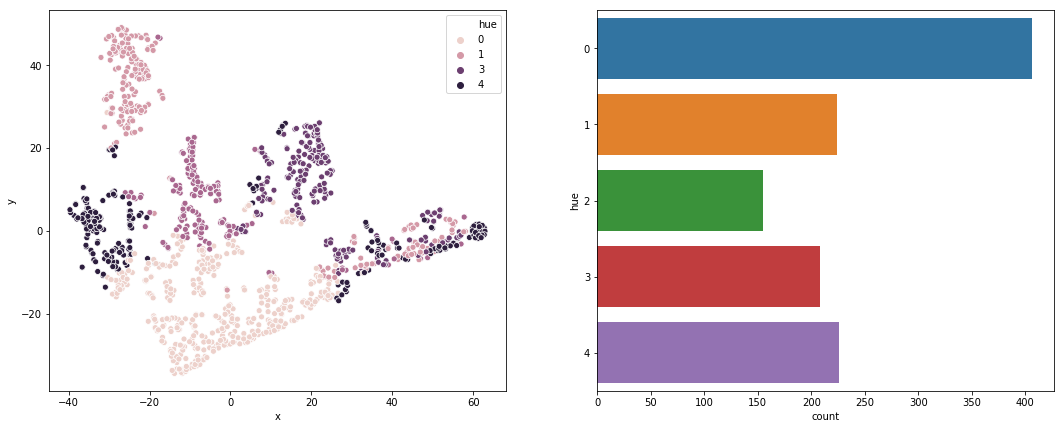

In [18]:
topic_map(nmf_cv, nmf)

In [19]:
def plot_top_term_weights(terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

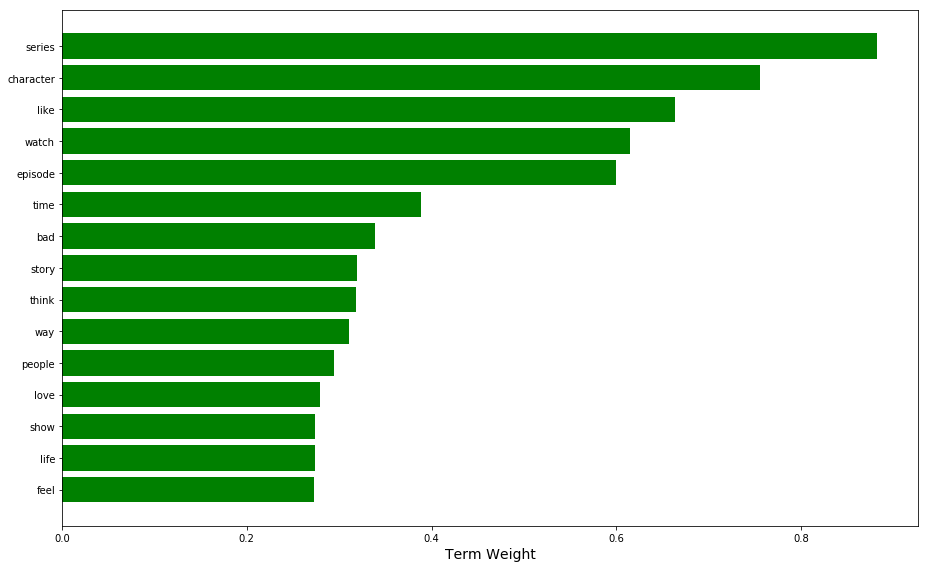

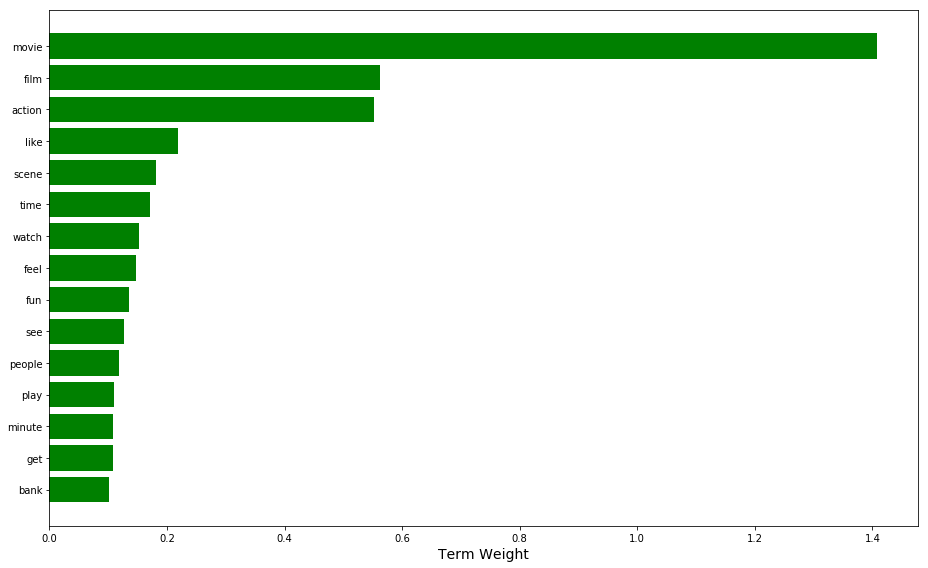

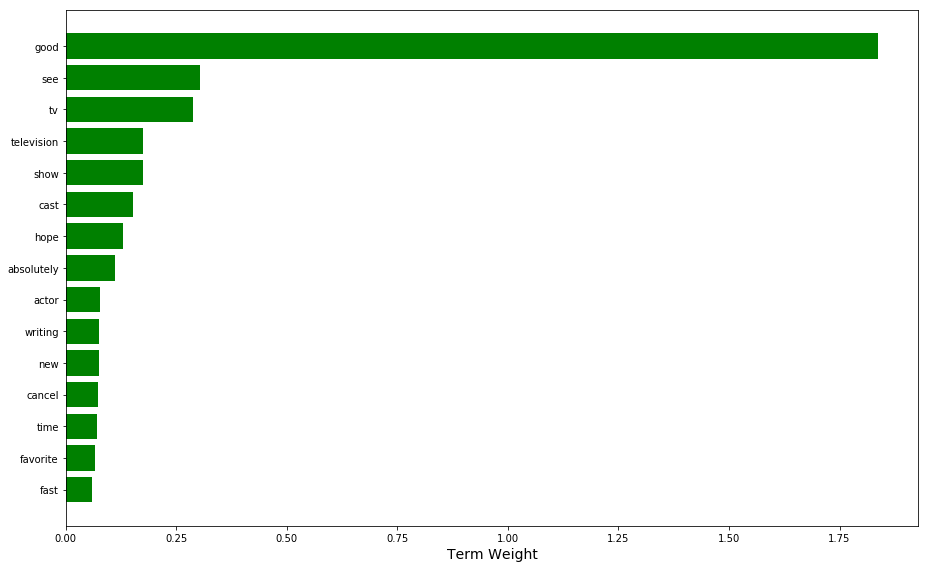

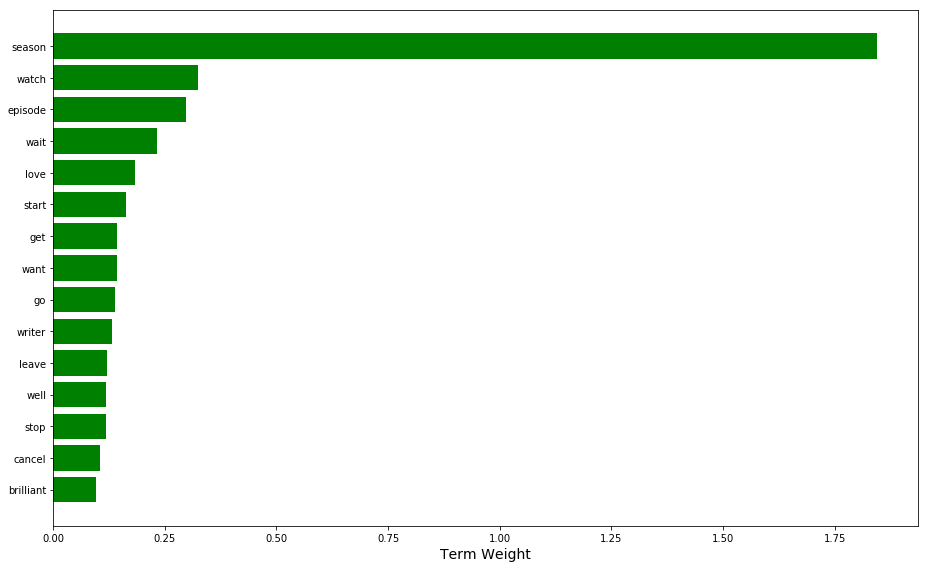

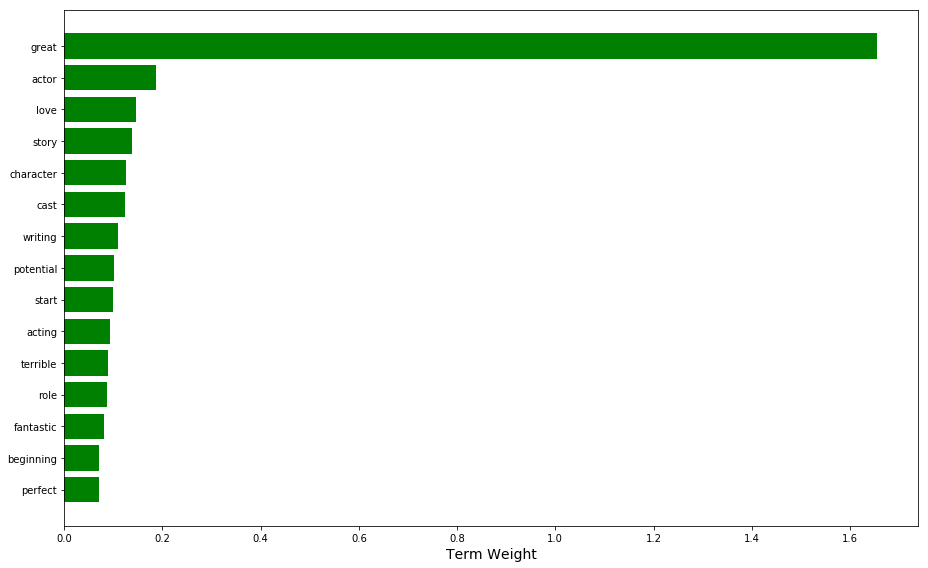

In [20]:
for t in range(n_components):
    plot_top_term_weights(cv_feature_names, nmf.components_, t, 15)

Upon initial look a few things pop out:

1) The NMF topics seem much more high level and it seems like there is some seperation between the topics, with some topics appearing better than other. The topics are almost too general though and difficult to see clear differences between the various topics.

2) The LDA topics are are made up largely one large general 'TV Show' group, but has some other very specific topic groups. For example a detective story topic with Reviews from shows like Mindhunter & True Detective making up a bulk of these reviews.A crime action movie topic with movies like John Wick & Widows, and a comic book movie/TV show genre with shows like Amazon's The Boys.

Overall it seems like the LDA model performs better than the NMF for based on the quality a seperations between the topics.